
## Regression Using Random Forests


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#reading_data">Reading the data in</a></li>
        <li><a href="#understanding_data">Understanding the Problem and Data</a></li>
        <li><a href="#data_exploration">Data Exploration</a></li>
        <li><a href="#simple_regression">Random Forest Regression Model</a></li>
    </ol>
</div>
<br>
<hr>

### Importing Needed packages


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline

<h2 id="reading_data">Reading the data in</h2>
Using Panda's read_csv as before

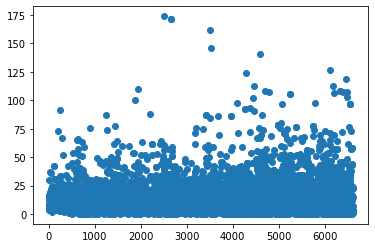

In [2]:
path_to_file ="/Users/babylon/Documents/Teaching/ML/ML2021/Data/septic_shock.csv"
septic_shock_data = pd.read_csv(path_to_file, encoding='utf-8')

plt.scatter(septic_shock_data.index, septic_shock_data['los'])

We can see that there is a large variation in length of stay, with the maximum stay having a length of 175 days



<h2 id="understanding_data">Understanding the Problem & Data</h2>

### `Septic_shock_data.csv`:

- We would like to predict the length of hospital stay __upto 10 days__. How would we formulate the problem?
- We have used this dataset before. 
    - The features included are:
        - Age (column 0)
        - Gender (column 1)
        - comorbidity_elixhauser (column 4)
        - Overall sofa (column 5)
        - (Overall) Sofa (column 6)
        - SOFA subcomponents (columns 7-12)
    - Outcome: the length of stay at the hospital: los(column 2)       

In [3]:
septic_shock_data.head()

,age,gender,los,hospital_mortality,comorbidity_elixhauser,sofa,respiration,coagulation,liver,cardio,cns,renal
0,28,1,6.083333,0,4,2,0,0,1,0,0,1
1,79,0,7.750000,0,3,2,0,0,0,2,0,0
2,42,1,17.041667,0,11,2,0,0,0,2,0,0
3,54,1,8.125000,0,0,2,0,1,0,0,1,0
4,66,0,12.000000,0,4,2,0,0,0,2,0,0


- Since we are only interested in los as an outcome, and we previously saw that gender is not relevant to predicting outcomes, we can create a smaller dataframe to contain the featuers and outcome we are interested in
- Features: 
    - age
    - comorbidity_elixhauser
    - sofa
    - respiration
    - coagulation
    - liver
    - cardio
    - cns
    - renal
- outcome:
    - los

In [4]:
septic_shock_regression_df = septic_shock_data[['age','comorbidity_elixhauser','sofa','respiration','coagulation','liver','cardio','cns','renal','los']]

septic_shock_regression_df.head()

,age,comorbidity_elixhauser,sofa,respiration,coagulation,liver,cardio,cns,renal,los
0,28,4,2,0,0,1,0,0,1,6.083333
1,79,3,2,0,0,0,2,0,0,7.750000
2,42,11,2,0,0,0,2,0,0,17.041667
3,54,0,2,0,1,0,0,1,0,8.125000
4,66,4,2,0,0,0,2,0,0,12.000000


- Moreover, since we are interested in predicting los upto 10 days, it does not make sense to train the model on the entire dataset. 
- It is therefore to extract a subset of the dataframe containing those entries whose los is less than 10 days: 

In [5]:
septic_shock_regression_df = septic_shock_regression_df.loc[septic_shock_regression_df.los<10]

<h2 id="data_exploration">Data Exploration</h2>
Lets first have a descriptive exploration on our data.

In [6]:
# summarize the data
septic_shock_regression_df.describe()

,age,comorbidity_elixhauser,sofa,respiration,coagulation,liver,cardio,cns,renal,los
count,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000
mean,67.976441,8.917400,7.600624,1.680670,0.766960,0.403066,2.619359,0.816917,1.329833,5.377566
std,15.134801,8.266998,3.686966,1.601369,0.936313,0.883254,1.626422,1.285585,1.449582,2.734690
min,16.000000,-14.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667
25%,58.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.541667
50%,70.000000,7.000000,7.000000,2.000000,0.000000,0.000000,3.000000,0.000000,1.000000,5.625000
75%,80.000000,14.000000,10.000000,3.000000,1.000000,0.000000,4.000000,1.000000,2.000000,7.625000
max,90.000000,50.000000,22.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,9.958333


#### Creating train and test dataset
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the data. It is more realistic for real world problems.

This means that we know the outcome of each data point in this dataset, making it great to test with! And since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing. (More about this tomorrow!)

Lets split our dataset into train and test sets. We have previously used train_test_split for this. Let's try another way:
  1. create a mask to select random rows using __np.random.rand()__ function: 
  2. Dsignate 90% of the entire data for training, and the 10% for testing.

In [7]:
mask = np.random.rand(len(septic_shock_regression_df)) < 0.9
train = septic_shock_regression_df[mask]
test = septic_shock_regression_df[~mask]

In [8]:

# Create Training and test data

train_x = np.asanyarray(train[['age','comorbidity_elixhauser','sofa','respiration','coagulation','liver','cardio','cns','renal']])
train_y = (train[['los']]).values.ravel()

test_x = np.asanyarray(test[['age','comorbidity_elixhauser','sofa','respiration','coagulation','liver','cardio','cns','renal']])
test_y = (test[['los']]).values.ravel()


2. Create a Random Forest Regressor. Let's go with the parameters below. We will looking into searching for the optimal parameters tomorrow

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(random_state = 42, n_estimators = 1000, max_features=4)


3. Fit the random forest regressor to the training data and make the predictions on the test set

In [10]:
rf_regressor.fit(train_x, train_y)  
y_pred= rf_regressor.predict(test_x)  


print(y_pred.shape)
print(test_y.shape)


(346,)
(346,)


#### Evaluation
we compare the actual values and predicted values to calculate the accuracy of a regression model. Evaluation metrics provide a key role in the development of a model, as it provides insight to areas that require improvement.

There are different model evaluation metrics for regression problems, lets use MSE here to calculate the accuracy of our model based on the test set. Summary of regressione evaluation metrics: 
<ul>
    <li> R²: represents the proportion of variance explained by your model.</li>
    <li> Mean absolute error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.</li>
    <li> Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean absolute error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.</li>
    <li> Root Mean Squared Error (RMSE): This is the square root of the Mean Square Error. </li>
  
</ul>

You can read more about the different metrics in ths Towards Data Science article: https://towardsdatascience.com/which-evaluation-metric-should-you-use-in-machine-learning-regression-problems-20cdaef258e

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt


print("Mean Square error: %.2f" %mean_squared_error(test_y, y_pred))
print("Root Mean Square error: %.2f" %sqrt(mean_squared_error(test_y, y_pred)))
print("Mean Absolute error: %.2f" %mean_absolute_error(test_y, y_pred))
print("R2 score : %.2f" %r2_score(test_y, y_pred))


Mean Square error: 7.03
Root Mean Square error: 2.65
Mean Absolute error: 2.15
R2 score : 0.02


- The perfect regressor would provide an MSE of zero. The further we are from zero, the lower the accuracy of the model. 
- However, there are no 'right' and 'wrong' values for MSE. Our aim as desginers of ML pipelines is to try to reduce the error by: 
    - Careful feature selection
    - Improved training/test splits (more on this in Day 3)
    - Good hyperparameter tuning (more on this in Day 3)
- This blog post has a nice introduction to MSE: https://www.bmc.com/blogs/mean-squared-error-r2-and-variance-in-regression-analysis/

##### Feature Importance
- We can also plot the feature importance to understand the contribution of the individual faetures to the overall regression. 

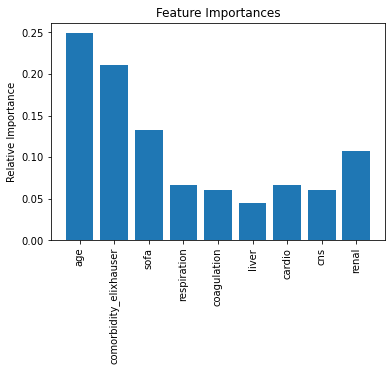

In [12]:
feature_importance_vector = rf_regressor.feature_importances_

feature_names=septic_shock_regression_df.columns[[0,1,2,3,4,5,6,7,8]]

plt.figure(1)
plt.title('Feature Importances')
plt.bar(range(len(feature_importance_vector)), feature_importance_vector)

plt.xticks(range(len(feature_importance_vector)), feature_names, rotation='vertical')
plt.ylabel('Relative Importance')
plt.show()

##### Visualise regression via plots
- Let's plot the predicted vs the actual values of length of stay

No handles with labels found to put in legend.


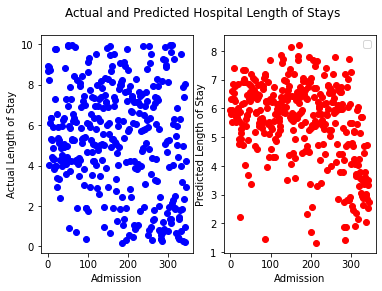

In [13]:

#fig, ax = plt.subplots(ncols=2, figsize=(10,4))
fig, ax = plt.subplots(1,2)
fig.suptitle('Actual and Predicted Hospital Length of Stays')
ax[0].plot(range(0,len(test_y)), test_y, 'bo', label = 'Actual')

ax[0].set(xlabel='Admission', ylabel='Actual Length of Stay')

# Plot the predicted values

ax[1].plot(range(0,len(y_pred)), y_pred, 'ro')
ax[1].set(xlabel='Admission', ylabel='Predicted Length of Stay')

plt.legend()
# Graph labels




### Your Task: Including Less Features in Creating the regression model

1. Re-create the regression model without the SOFA subcomponents from the featureset, i.e. the features are:
    - age
    - elixhauser_comorbidity
    - sofa
2. Is the performance better or worse? is it comparable? 
3. You can visualise the feature importance similarly to the above task. 
4. Can you plot the predicted and actual length of stays as int he example above?
    

In [38]:
### Your solution here ### 